In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
# hand written digits
batch_size = 256
ds = tfds.load('mnist', split='train', shuffle_files=True)

ds = ds.shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
for example in ds.take(1):
  image, label = example["image"], example["label"]

2022-07-06 22:28:52.303327: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 22:28:52.490520: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [3]:
# generator
def generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(256,input_shape = (100,),use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(512,use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(28*28*1, use_bias = False, activation = 'tanh'))
    model.add(layers.Reshape((28,28,1)))
    return model


In [4]:
# discriminator
def discriminator_model():
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape = (28,28,1)))
    
    model.add(layers.Dense(512,use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(256,use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1))
    
    return model


In [5]:
def discriminator_loss(disc_output_for_real_image, disc_output_for_gen_image):
    loss = tf.math.log(disc_output_for_real_image) + tf.math.log(1-disc_output_for_gen_image)
    return -1 * loss  # maximize the value
    
def generator_loss(disc_output_for_gen_image):
    loss = tf.math.log(1 - disc_output_for_gen_image)
    return loss

In [6]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_out, fake_out):
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

def generator_loss(fake_out):
    return cross_entropy(tf.ones_like(fake_out), fake_out)


In [7]:
generator_opt = keras.optimizers.Adam(1e-4)
discriminator_opt = keras.optimizers.Adam(1e-4)

In [8]:
generator = generator_model()
discriminator = discriminator_model()

In [9]:
k = 3
def train_step(images):
    
    # first update discriminator for 3 epochs
    for i in range(k):
        noise = tf.random.normal([batch_size, noise_dim])  
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            disc_output_for_real_image = discriminator(images['image'], training = True)
            gen_image = generator(noise, training=True)
            disc_output_for_gen_image = discriminator(gen_image, training = True)
            disc_loss = discriminator_loss(disc_output_for_real_image, disc_output_for_gen_image)
            
        gradient_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_opt.apply_gradients(zip(gradient_disc, discriminator.trainable_variables))
        
        
    # then update generator
    noise = tf.random.normal([batch_size, noise_dim])  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_image = generator(noise, training=True)
        disc_output_for_gen_image = discriminator(gen_image, training = True)
        gen_loss = generator_loss(disc_output_for_gen_image)
        
    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_opt.apply_gradients(zip(gradient_gen, generator.trainable_variables))    

In [10]:
def generate_plot_image(gen_model, test_noise):
    pre_images = gen_model(test_noise, training = False)
    fig = plt.figure(figsize = (4,4))
    for i in range(pre_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((pre_images[i,:,:,0] +1)/2, cmap = 'gray')
        plt.axis('off')
    plt.show()
    

In [11]:
noise_dim = 100
num_exp_to_generate = 16
seed = tf.random.normal([num_exp_to_generate,noise_dim])
def train(ds, epochs):
    for epoch in range(epochs):
        for image_batch in ds:
            train_step(image_batch)
            print('.', end = '')
        generate_plot_image(generator, seed)
        print('Epoch:'+str(epoch))
        

In [12]:
#x = 300
#noise = tf.random.normal([x, 200]) 
#for i in range(0,x-1):
#    plt.imshow(generator(noise)[i])
#    plt.show()

...........................................................................................................................................................................................................................................

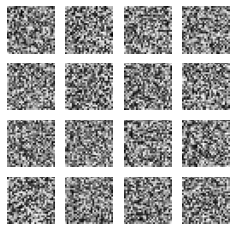

Epoch:0
...........................................................................................................................................................................................................................................

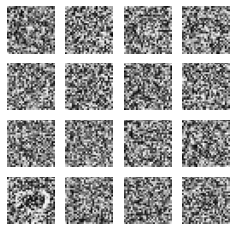

Epoch:1
...........................................................................................................................................................................................................................................

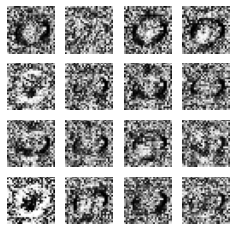

Epoch:2
...........................................................................................................................................................................................................................................

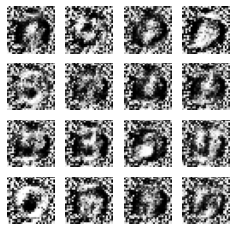

Epoch:3
...........................................................................................................................................................................................................................................

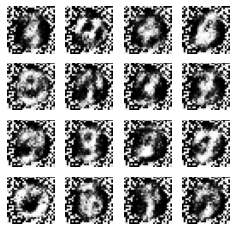

Epoch:4
...........................................................................................................................................................................................................................................

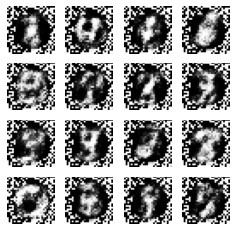

Epoch:5
...........................................................................................................................................................................................................................................

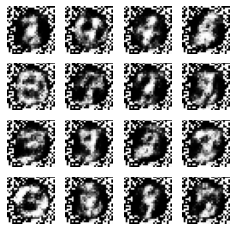

Epoch:6
...........................................................................................................................................................................................................................................

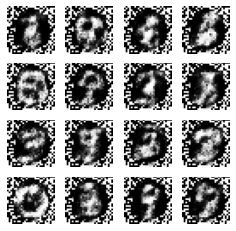

Epoch:7
...........................................................................................................................................................................................................................................

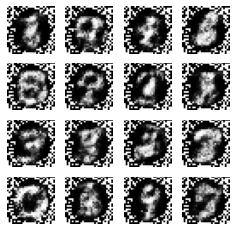

Epoch:8
...........................................................................................................................................................................................................................................

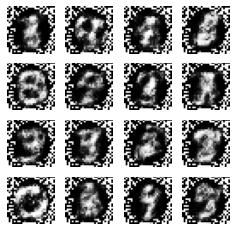

Epoch:9
...........................................................................................................................................................................................................................................

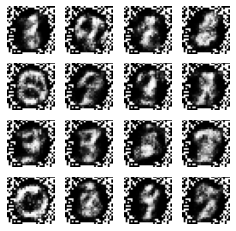

Epoch:10
...........................................................................................................................................................................................................................................

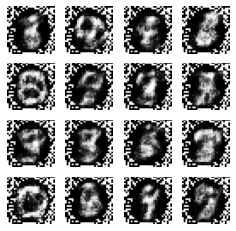

Epoch:11
...........................................................................................................................................................................................................................................

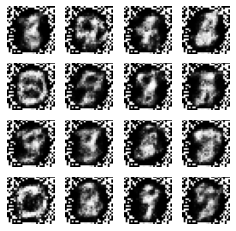

Epoch:12
...........................................................................................................................................................................................................................................

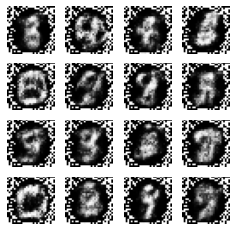

Epoch:13
...........................................................................................................................................................................................................................................

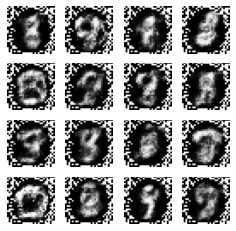

Epoch:14
...........................................................................................................................................................................................................................................

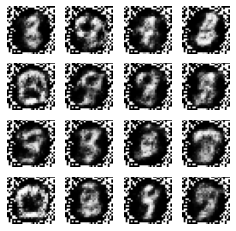

Epoch:15
...........................................................................................................................................................................................................................................

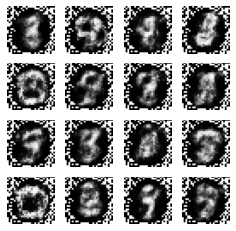

Epoch:16
...........................................................................................................................................................................................................................................

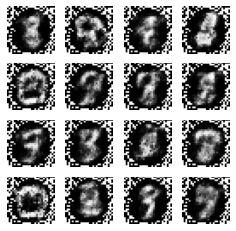

Epoch:17
...........................................................................................................................................................................................................................................

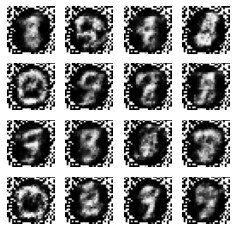

Epoch:18
...........................................................................................................................................................................................................................................

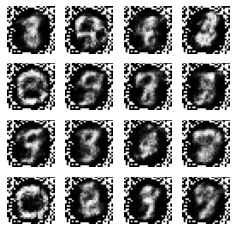

Epoch:19
...........................................................................................................................................................................................................................................

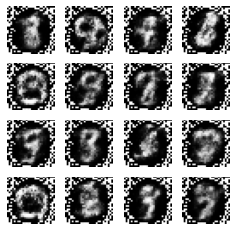

Epoch:20
...........................................................................................................................................................................................................................................

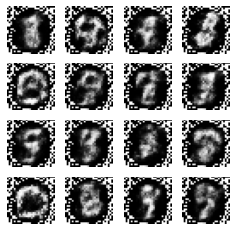

Epoch:21
...........................................................................................................................................................................................................................................

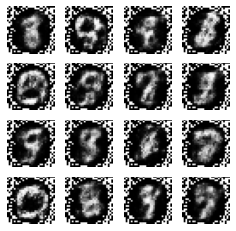

Epoch:22
...........................................................................................................................................................................................................................................

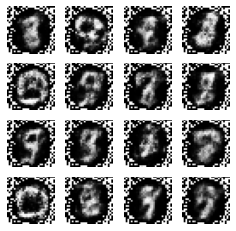

Epoch:23
...........................................................................................................................................................................................................................................

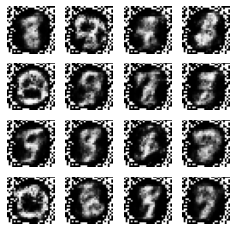

Epoch:24
...........................................................................................................................................................................................................................................

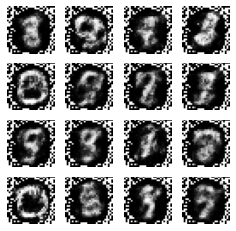

Epoch:25
...........................................................................................................................................................................................................................................

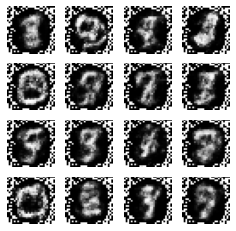

Epoch:26
...........................................................................................................................................................................................................................................

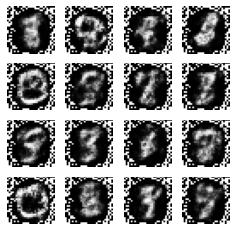

Epoch:27
...........................................................................................................................................................................................................................................

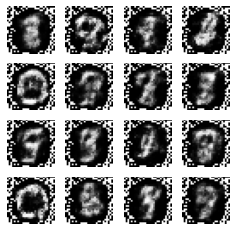

Epoch:28
...........................................................................................................................................................................................................................................

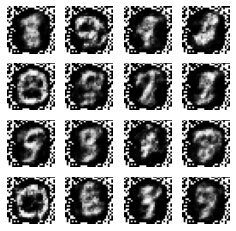

Epoch:29
...........................................................................................................................................................................................................................................

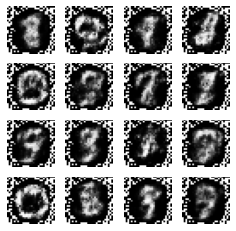

Epoch:30
...........................................................................................................................................................................................................................................

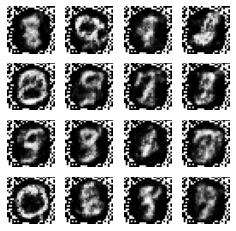

Epoch:31
...........................................................................................................................................................................................................................................

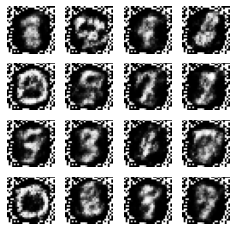

Epoch:32
...........................................................................................................................................................................................................................................

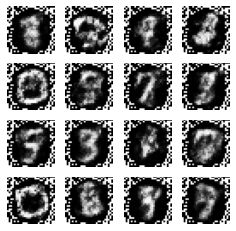

Epoch:33
...........................................................................................................................................................................................................................................

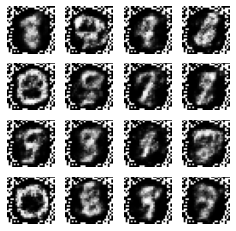

Epoch:34
...........................................................................................................................................................................................................................................

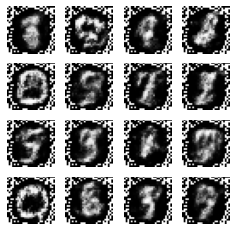

Epoch:35
...........................................................................................................................................................................................................................................

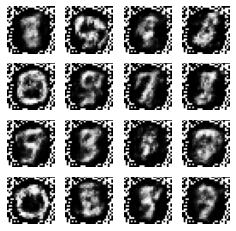

Epoch:36
...........................................................................................................................................................................................................................................

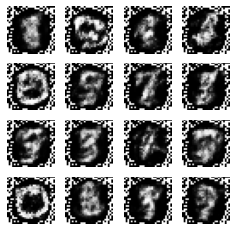

Epoch:37
...........................................................................................................................................................................................................................................

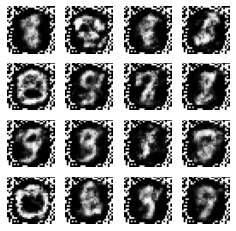

Epoch:38
...........................................................................................................................................................................................................................................

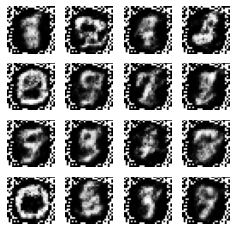

Epoch:39


In [13]:
epochs = 40
train(ds, epochs)

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

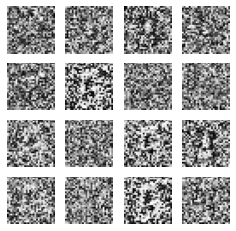

Epoch:0
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

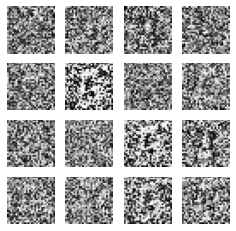

Epoch:1
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

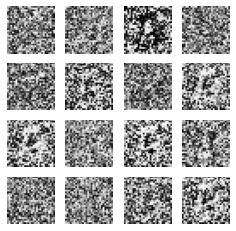

Epoch:2
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

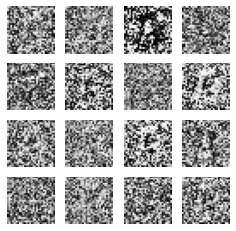

Epoch:3
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

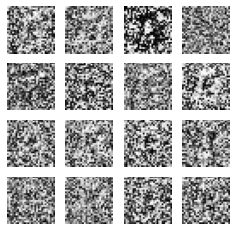

Epoch:4
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

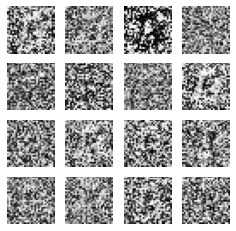

Epoch:5
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

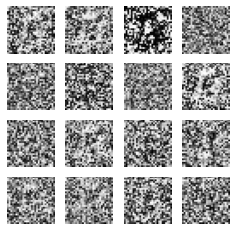

Epoch:6
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

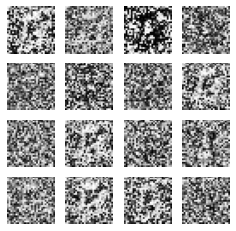

Epoch:7
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

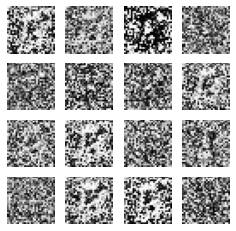

Epoch:8
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

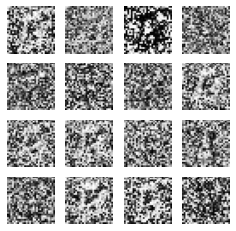

Epoch:9
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

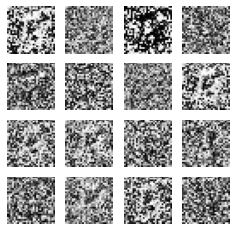

Epoch:10
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

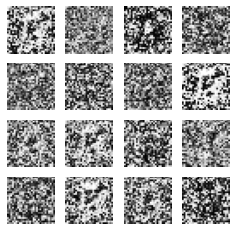

Epoch:11
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

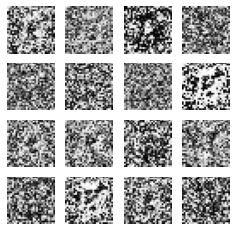

Epoch:12
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

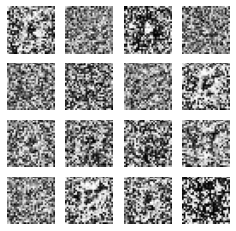

Epoch:13
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

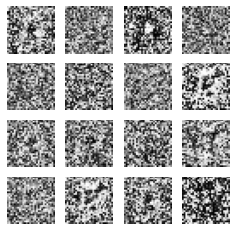

Epoch:14
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

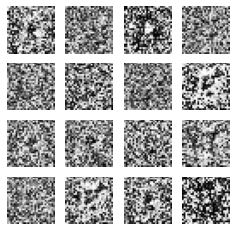

Epoch:15
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

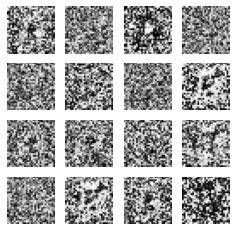

Epoch:16
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

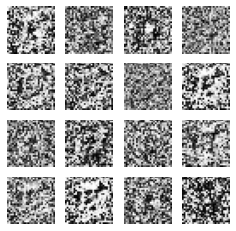

Epoch:17
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

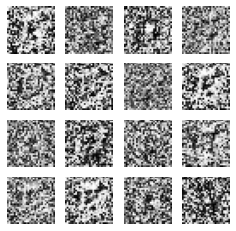

Epoch:18
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

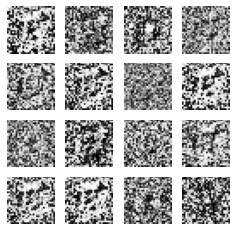

Epoch:19


In [89]:
epochs = 20
train(ds, epochs)

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

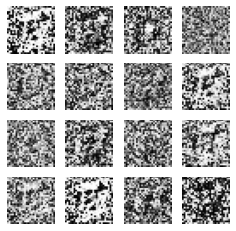

Epoch:0
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

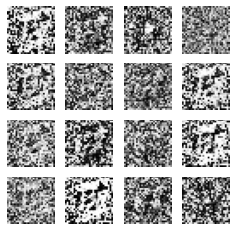

Epoch:1
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

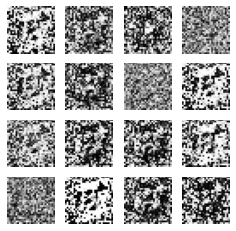

Epoch:2
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

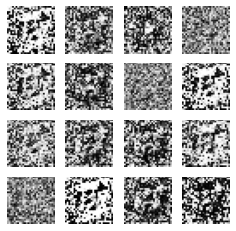

Epoch:3
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

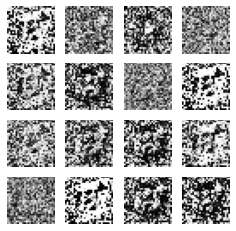

Epoch:4
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

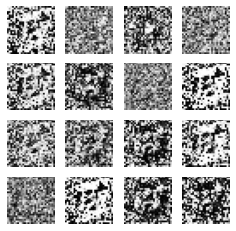

Epoch:5
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

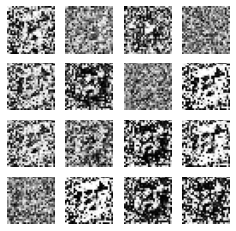

Epoch:6
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

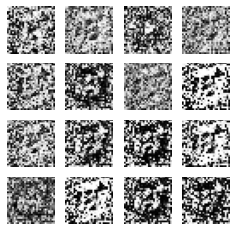

Epoch:7
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

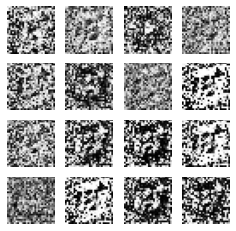

Epoch:8
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

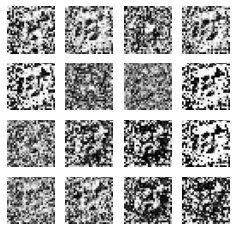

Epoch:9
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

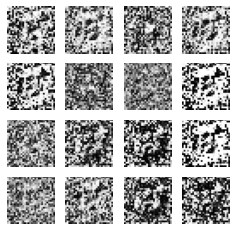

Epoch:10
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

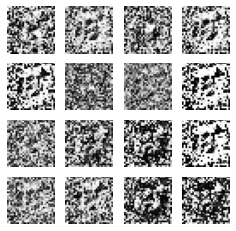

Epoch:11
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

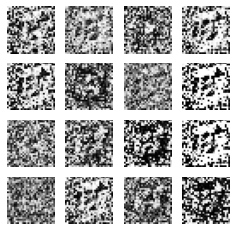

Epoch:12
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

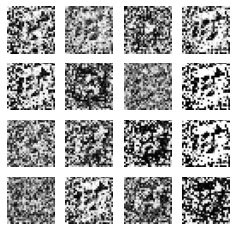

Epoch:13
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

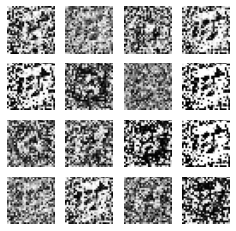

Epoch:14
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [90]:
epochs = 50
train(ds, epochs)

###### generator.summary()

In [51]:
len(G_loss)

1220

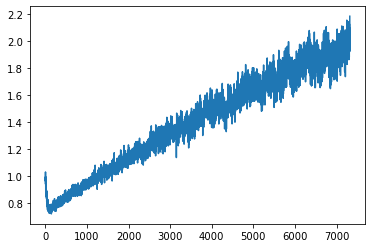

In [54]:
G_epoch_num = list(range(len(G_loss)))
plt.plot(G_epoch_num,G_loss)


In [ ]:
noise = tf.random.normal([batch_size, noise_dim])
noise.shape

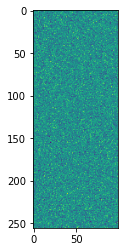

In [460]:
plt.imshow(noise)

In [461]:
gen_image = generator(noise)

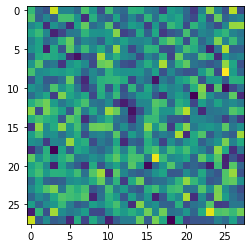

In [462]:
plt.imshow(gen_image[0])

In [480]:
discriminator(gen_image).shape

TensorShape([256, 1])

In [485]:
for image_batch in datasets:
    print(image_batch.shape)
    discriminator(image_batch).shape
    discriminator(gen_image).shape

(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 